In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector


In [2]:
# ----- 参数设置 -----
n_qubits = 10
J = 1.0
h = 1.0

In [3]:
# ----- 构建 1D 横场 Ising Hamiltonian -----
def build_ising_hamiltonian(n, J, h):
    paulis = []
    coeffs = []

    # Z_i Z_{i+1} 项
    for i in range(n - 1):
        label = ['I'] * n
        label[i] = 'Z'
        label[i + 1] = 'Z'
        paulis.append(''.join(reversed(label)))  # Qiskit从右往左
        coeffs.append(-J)

    # X_i 项
    for i in range(n):
        label = ['I'] * n
        label[i] = 'X'
        paulis.append(''.join(reversed(label)))
        coeffs.append(-h)

    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

hamiltonian = build_ising_hamiltonian(n_qubits, J, h)

In [4]:
def create_physically_inspired_ansatz(n_qubits, h, J, reps=3):
    params = ParameterVector('θ', length=2 * n_qubits * reps)
    qc = QuantumCircuit(n_qubits)

    # 初态准备：根据 h/J 设置 RY 角度，模拟磁化方向
    init_angle = 2 * np.arctan(h / J)  # 乘 2 是因为 RY(θ)|0> = cos(θ/2)|0> + sin(θ/2)|1>
    for i in range(n_qubits):
        qc.ry(init_angle, i)

    # Ansatz 部分：多层旋转+纠缠结构
    for rep in range(reps):
        for i in range(n_qubits):
            qc.ry(params[2 * n_qubits * rep + i], i)
            qc.rx(params[2 * n_qubits * rep + n_qubits + i], i)
        for i in range(n_qubits - 1):
            qc.cx(i, i + 1)

    return qc, list(params)



ansatz_circuit, ansatz_params = create_physically_inspired_ansatz(n_qubits, h, J, reps=4)

In [5]:
# ----- 构建 EstimatorQNN -----
estimator = Estimator()
qnn = EstimatorQNN(
    circuit=ansatz_circuit,
    observables=hamiltonian,
    input_params=[],
    weight_params=ansatz_params,
    estimator=estimator
)


/var/folders/d9/_3jh3gcd7m5gl50nsj1mgls80000gn/T/ipykernel_23646/1738038090.py:3: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


In [6]:
# ----- 用 TorchConnector 包装 QNN -----
qnn_model = TorchConnector(qnn)

In [7]:
# ----- 动态可视化回调函数 -----
objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Ground state energy value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Ground state energy value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.grid(True)
    plt.show()

In [8]:
# 使用 Adagrad 优化器
'''optimizer = torch.optim.Adagrad(qnn_model.parameters(), lr=0.1)  # 可调整学习率'''

'optimizer = torch.optim.Adagrad(qnn_model.parameters(), lr=0.1)  # 可调整学习率'

In [9]:
# 使用随机梯度下降 (SGD) 优化器
'''optimizer = torch.optim.SGD(qnn_model.parameters(), lr=0.01)  # 可根据需要调整学习率'''


'optimizer = torch.optim.SGD(qnn_model.parameters(), lr=0.01)  # 可根据需要调整学习率'

In [10]:
# 调整 Adam 优化器的学习率
optimizer = torch.optim.Adam(qnn_model.parameters(), lr=0.01)  # 调整学习率


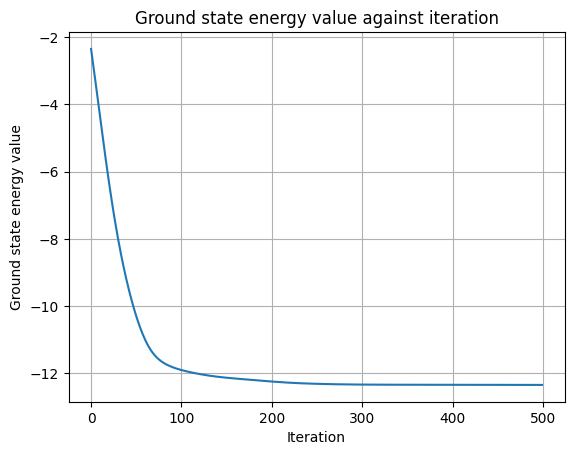

In [11]:
# ----- 训练过程 -----
for epoch in range(500):
    optimizer.zero_grad()
    output = qnn_model()
    loss = output.mean()
    loss.backward()
    optimizer.step()
    callback_graph(qnn_model.weight, loss.item())

In [13]:
# ----- 输出结果 -----
final_weights = qnn_model.weight.detach().numpy()
estimator = Estimator()

# Ground state energy
E0 = estimator.run(circuits=ansatz_circuit, observables=hamiltonian, parameter_values=[final_weights]).result().values[0]
print(f"\nGround state energy E0 ≈ {E0:.6f}")

# <Z> 总磁化
z_obs = SparsePauliOp.from_list([(f"{'I'*i + 'Z' + 'I'*(n_qubits - i - 1)}", 1.0) for i in range(n_qubits)])
mz = estimator.run(circuits=ansatz_circuit, observables=z_obs, parameter_values=[final_weights]).result().values[0] / n_qubits
print(f"Magnetization <Z> ≈ {mz:.6f}")

# <X> 总磁化
x_obs = SparsePauliOp.from_list([(f"{'I'*i + 'X' + 'I'*(n_qubits - i - 1)}", 1.0) for i in range(n_qubits)])
mx = estimator.run(circuits=ansatz_circuit, observables=x_obs, parameter_values=[final_weights]).result().values[0] / n_qubits
print(f"Magnetization <X> ≈ {mx:.6f}")


Ground state energy E0 ≈ -12.342711
Magnetization <Z> ≈ -0.001404
Magnetization <X> ≈ 0.748171
